In [1]:
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import (
    RandomForestRegressor,
    BaggingRegressor,
    RandomForestClassifier,
)

In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv("train_data.csv")

In [5]:
dft = pd.read_csv("test_data.csv")

## Imputation

+ Rotary Engines and Electric Engines lack cylinders so they are filled with **0 in Engine Cylinders**.
+ **Engine Horsepower** is missing in some cases of electric engines. So the **mean value** is filled. However this **can be improved** since this is an important predictor of MSRP.
+ **Number of Doors** is mostly 4 so missing values were filled with **4**.

In [6]:
df.isna().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              65
Engine Cylinders       23
Transmission Type       0
Driven_Wheels           0
Number of Doors         4
Market Category      3376
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

In [7]:
df[df["Number of Doors"].isnull()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
2456,Tesla,Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,"Exotic,Performance",Large,Sedan,105,102,1391,79500
4074,Tesla,Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,rear wheel drive,NaN,"Exotic,Performance",Large,Sedan,100,97,1391,74500
4668,Tesla,Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,"Exotic,High-Performance",Large,Sedan,105,92,1391,134500
10196,Tesla,Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,"Exotic,Performance",Large,Sedan,107,101,1391,71000


In [8]:
df[df["Model"] == "Model S"]["Number of Doors"]

278      4.0
1526     4.0
1626     4.0
2222     4.0
2456     NaN
3547     4.0
3882     4.0
4074     NaN
4087     4.0
4668     NaN
6529     4.0
7552     4.0
8626     4.0
9040     4.0
10048    4.0
10196    NaN
10308    4.0
Name: Number of Doors, dtype: float64

In [9]:
df.loc[df["Number of Doors"].isnull(), "Number of Doors"] = 4

In [10]:
df[df["Engine HP"].isnull()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
278,Tesla,Model S,2015,electric,NaN,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Exotic,Performance",Large,Sedan,90,88,1391,80000
343,Kia,Soul EV,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,NaN,Compact,Wagon,92,120,1720,33700
744,Ford,Escape,2017,regular unleaded,NaN,4.0,AUTOMATIC,all wheel drive,4.0,Crossover,Compact,4dr SUV,28,22,5657,26850
820,Chevrolet,Impala,2016,flex-fuel (unleaded/natural gas),NaN,6.0,AUTOMATIC,front wheel drive,4.0,"Flex Fuel,Performance",Large,Sedan,25,17,1385,37570
955,Lincoln,MKZ,2017,regular unleaded,NaN,4.0,AUTOMATIC,front wheel drive,4.0,"Luxury,Hybrid",Midsize,Sedan,38,41,61,39510
1033,Ford,Freestar,2005,regular unleaded,NaN,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Passenger Minivan,22,16,5657,26530
1110,Ford,Focus,2017,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,99,110,5657,29120
1519,Lincoln,MKZ,2017,regular unleaded,NaN,4.0,AUTOMATIC,front wheel drive,4.0,"Luxury,Hybrid",Midsize,Sedan,38,41,61,36760
1526,Tesla,Model S,2015,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,4.0,"Exotic,High-Performance",Large,Sedan,106,95,1391,85000
1595,Chevrolet,Impala,2015,flex-fuel (unleaded/natural gas),NaN,6.0,AUTOMATIC,front wheel drive,4.0,"Flex Fuel,Performance",Large,Sedan,25,17,1385,40660


In [11]:
ENGINE_HP_MEAN = df["Engine HP"].mean()
df.loc[df["Engine HP"].isnull(), "Engine HP"] = ENGINE_HP_MEAN

In [12]:
df[df["Engine Cylinders"].isnull()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
813,Mazda,RX-8,2011,premium unleaded (required),232.0,NaN,MANUAL,rear wheel drive,4.0,Performance,Compact,Coupe,22,16,586,26795
925,Toyota,RAV4 EV,2012,electric,154.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Crossover,Midsize,4dr SUV,74,78,2031,49800
1131,Mazda,RX-8,2010,premium unleaded (required),232.0,NaN,MANUAL,rear wheel drive,4.0,Performance,Compact,Coupe,22,16,586,26645
1785,Mazda,RX-8,2010,premium unleaded (required),212.0,NaN,AUTOMATIC,rear wheel drive,4.0,Performance,Compact,Coupe,23,16,586,26645
1938,Mazda,RX-8,2011,premium unleaded (required),212.0,NaN,AUTOMATIC,rear wheel drive,4.0,Performance,Compact,Coupe,23,16,586,26795
2181,Chevrolet,Bolt EV,2017,electric,200.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,110,128,1385,40905
2395,Mazda,RX-8,2010,premium unleaded (required),232.0,NaN,MANUAL,rear wheel drive,4.0,Performance,Compact,Coupe,22,16,586,32140
3012,Mazda,RX-8,2009,premium unleaded (required),212.0,NaN,AUTOMATIC,rear wheel drive,4.0,Performance,Compact,Coupe,23,16,586,28560
4760,Mazda,RX-8,2009,premium unleaded (required),212.0,NaN,AUTOMATIC,rear wheel drive,4.0,Performance,Compact,Coupe,23,16,586,31700
5052,Mazda,RX-8,2009,premium unleaded (required),232.0,NaN,MANUAL,rear wheel drive,4.0,Performance,Compact,Coupe,22,16,586,31930


In [13]:
df.loc[df["Model"] == "RX-8", "Engine Cylinders"] = 0

In [14]:
df.loc[df["Model"] == "RX-7", "Engine Cylinders"] = 0

In [15]:
df.loc[df["Engine Cylinders"].isnull(), "Engine Cylinders"] = 0

In [16]:
df.isna().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP               0
Engine Cylinders        0
Transmission Type       0
Driven_Wheels           0
Number of Doors         0
Market Category      3376
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

## Exploration
+ All columns in the train_data and test_data were compared, and it was found that **some columns in test_data contain values that are absent in train_data** e.g. 
    + Make
    + Model
    + Engine Fuel Type
    + Market Category
+ These were therefore removed from the training data
+ The distribution of MSRP values was studies because **simple regression was performing very poorly**.
+ It was found that the **MSRP values** could be **divided into four categories**.

In [17]:
df.head().T

,0,1,2,3,4
Make,GMC,Scion,Hyundai,GMC,Mazda
Model,Terrain,xD,Veloster,Sierra 1500 Classic,B-Series
Year,2017,2013,2016,2007,2001
Engine Fuel Type,regular unleaded,regular unleaded,regular unleaded,regular unleaded,regular unleaded
Engine HP,182,128,132,285,150
Engine Cylinders,4,4,4,8,6
Transmission Type,AUTOMATIC,AUTOMATIC,AUTOMATED_MANUAL,AUTOMATIC,MANUAL
Driven_Wheels,front wheel drive,front wheel drive,front wheel drive,four wheel drive,rear wheel drive
Number of Doors,4,4,3,2,2
Market Category,Crossover,Hatchback,Hatchback,Flex Fuel,NaN


In [18]:
df.columns

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

In [19]:
df["Vehicle Size"].unique()

array(['Compact', 'Large', 'Midsize'], dtype=object)

In [20]:
df["Driven_Wheels"].unique()

array(['front wheel drive', 'four wheel drive', 'rear wheel drive',
       'all wheel drive'], dtype=object)

In [21]:
df["Vehicle Style"].unique()

array(['4dr SUV', '4dr Hatchback', '2dr Hatchback', 'Regular Cab Pickup',
       'Extended Cab Pickup', 'Sedan', 'Coupe', 'Convertible',
       'Crew Cab Pickup', '2dr SUV', 'Passenger Van', 'Wagon',
       'Cargo Minivan', 'Cargo Van', 'Passenger Minivan', 'Convertible SUV'], dtype=object)

In [22]:
df[df["Vehicle Size"] == "Compact"]["Vehicle Style"].unique()

array(['4dr SUV', '4dr Hatchback', '2dr Hatchback', 'Extended Cab Pickup',
       'Regular Cab Pickup', 'Coupe', 'Convertible', '2dr SUV',
       'Crew Cab Pickup', 'Sedan', 'Wagon', 'Passenger Minivan',
       'Passenger Van', 'Cargo Minivan', 'Convertible SUV', 'Cargo Van'], dtype=object)

In [23]:
df[df["Vehicle Size"] == "Midsize"]["Vehicle Style"].unique()

array(['4dr SUV', 'Convertible', 'Sedan', 'Passenger Van', 'Cargo Minivan',
       'Coupe', 'Cargo Van', 'Passenger Minivan', 'Wagon', '4dr Hatchback',
       '2dr SUV', '2dr Hatchback', 'Convertible SUV'], dtype=object)

In [24]:
df[df["Vehicle Size"] == "Large"]["Vehicle Style"].unique()

array(['Regular Cab Pickup', 'Sedan', 'Crew Cab Pickup', 'Wagon',
       'Extended Cab Pickup', '4dr SUV', 'Passenger Minivan', 'Cargo Van',
       'Passenger Van', '4dr Hatchback', 'Cargo Minivan', 'Coupe',
       'Convertible'], dtype=object)

In [25]:
df[df["Model"] == "Sierra 1500 Classic"].sort_values("MSRP", axis=0)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
5749,GMC,Sierra 1500 Classic,2007,regular unleaded,195.0,6.0,MANUAL,rear wheel drive,2.0,Flex Fuel,Large,Regular Cab Pickup,21,15,549,15840
826,GMC,Sierra 1500 Classic,2007,regular unleaded,195.0,6.0,MANUAL,rear wheel drive,2.0,Flex Fuel,Large,Regular Cab Pickup,21,15,549,16115
2246,GMC,Sierra 1500 Classic,2007,regular unleaded,195.0,6.0,AUTOMATIC,four wheel drive,2.0,Flex Fuel,Large,Regular Cab Pickup,17,14,549,20715
5792,GMC,Sierra 1500 Classic,2007,regular unleaded,195.0,6.0,MANUAL,rear wheel drive,2.0,Flex Fuel,Large,Regular Cab Pickup,21,15,549,20750
6372,GMC,Sierra 1500 Classic,2007,regular unleaded,195.0,6.0,AUTOMATIC,rear wheel drive,4.0,Flex Fuel,Large,Extended Cab Pickup,20,14,549,21465
546,GMC,Sierra 1500 Classic,2007,regular unleaded,285.0,8.0,AUTOMATIC,rear wheel drive,2.0,Flex Fuel,Large,Regular Cab Pickup,19,15,549,24140
477,GMC,Sierra 1500 Classic,2007,flex-fuel (unleaded/E85),295.0,8.0,AUTOMATIC,rear wheel drive,4.0,Flex Fuel,Large,Extended Cab Pickup,19,14,549,24515
9119,GMC,Sierra 1500 Classic,2007,regular unleaded,285.0,8.0,AUTOMATIC,rear wheel drive,4.0,Flex Fuel,Large,Extended Cab Pickup,19,15,549,25215
9531,GMC,Sierra 1500 Classic,2007,regular unleaded,285.0,8.0,AUTOMATIC,four wheel drive,4.0,Flex Fuel,Large,Extended Cab Pickup,18,14,549,25845
4270,GMC,Sierra 1500 Classic,2007,regular unleaded,285.0,8.0,AUTOMATIC,four wheel drive,2.0,Flex Fuel,Large,Regular Cab Pickup,18,14,549,25850


In [26]:
set(df["Vehicle Style"].unique()) == set(dft["Vehicle Style"].unique())

True

In [27]:
type(df["MSRP"][0])

numpy.int64

In [28]:
for col in df.columns:
    print(
        col,
        "contains no oov values",
        set(df[col].unique()) == set(dft[col].unique()),
        type(df[col][0]),
    )

Make contains no oov values False <class 'str'>
Model contains no oov values False <class 'str'>
Year contains no oov values True <class 'numpy.int64'>
Engine Fuel Type contains no oov values False <class 'str'>
Engine HP contains no oov values False <class 'numpy.float64'>
Engine Cylinders contains no oov values False <class 'numpy.float64'>
Transmission Type contains no oov values True <class 'str'>
Driven_Wheels contains no oov values True <class 'str'>
Number of Doors contains no oov values False <class 'numpy.float64'>
Market Category contains no oov values False <class 'str'>
Vehicle Size contains no oov values True <class 'str'>
Vehicle Style contains no oov values True <class 'str'>
highway MPG contains no oov values False <class 'numpy.int64'>
city mpg contains no oov values False <class 'numpy.int64'>
Popularity contains no oov values False <class 'numpy.int64'>
MSRP contains no oov values False <class 'numpy.int64'>


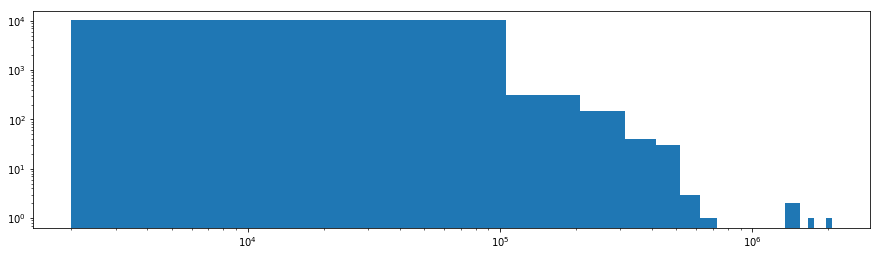

In [29]:
plt.figure(figsize=(15, 4))
ax = plt.gca()
ax.hist(df["MSRP"], bins=20, log=True)
ax.set_xscale("log")
# ax.set_xticks([0,10000,50000,100000,200000,500000, 1000000, 1500000, 2000000])
# ax.xticks = (range(8), [10**i for i in range(8)])
# ax.xlim=(0, 50000)

+ The figure above shows the distribution of MSRP values on log-log scale.
+ On the x-axis we can the values lie between **four categories: 0-e4, e4-e5, e5-e6, e6-inf**

In [30]:
df["MSRP"].describe()

count    1.072200e+04
mean     4.073484e+04
std      6.155895e+04
min      2.000000e+03
25%      2.107625e+04
50%      2.999500e+04
75%      4.230000e+04
max      2.065902e+06
Name: MSRP, dtype: float64

df['Model'].unique()

## MSRP_cat training

+ It was found that the **MSRP values** could be divided into four categories **ordinary/deluxe/luxury/super-luxury**
+ **Adding that** as a feature **improved the performance of regression model significantly**. It will be shown later.
+ Since this **new categorical feature** will be absent in test_data, therefore, **a classifier was trained to predict that**. And fortunately it performed extremely well too.

In [31]:
def get_msrp_cat(x):
    if x < 10 ** 4:
        return "ordinary"
    elif x < 10 ** 5:
        return "deluxe"
    elif x < 10 ** 6:
        return "luxury"
    else:
        return "super-luxury"

In [32]:
df.loc[:, "MSRP_cat"] = df["MSRP"].apply(get_msrp_cat)

Number of Driven Wheels and Vehicle Size are not categorical features
Altough I haven't plotted the graph between those and price, which might say against that. Will try that later.

In [33]:
driven_wheels_map = {
    "front wheel drive": 1,
    "four wheel drive": 2,
    "rear wheel drive": 0,
    "all wheel drive": 2,
}

vehicle_size_map = {"Compact": 0, "Large": 2, "Midsize": 1}

In [34]:
df.loc[:, "Driven_Wheels"] = df["Driven_Wheels"].apply(lambda x: driven_wheels_map[x])

In [35]:
df.loc[:, "Vehicle Size"] = df["Vehicle Size"].apply(lambda x: vehicle_size_map[x])

In [36]:
X_ = pd.get_dummies(
    df.drop(
        ["Make", "Model", "Engine Fuel Type", "Market Category", "MSRP", "MSRP_cat"],
        axis=1,
    )
)
y_ = df["MSRP_cat"]

In [37]:
y_true = []
y_pred = []
X, y = np.array(X_), np.array(y_)

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
# x_scaler.fit(X)
# y_scaler.fit(y.reshape(-1, 1))

kf = KFold(n_splits=10, shuffle=True, random_state=2019)
for i, (train_idx, test_idx) in tqdm(enumerate(kf.split(X))):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    #     X_train = x_scaler.transform(X_train)
    #     y_train = y_scaler.transform(y_train.reshape(-1, 1)).reshape(-1)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    y_true.append(y_test)
    y_pred.append(model.predict(X_test))
    #     y_pred.append(y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test))))

    print(
        "Train acc:",
        accuracy_score(y_train, model.predict(X_train)),
        "F1:",
        f1_score(y_train, model.predict(X_train), average="micro"),
        end=" ",
    )
    print(
        "Test acc:",
        accuracy_score(y_test, model.predict(X_test)),
        "F1:",
        f1_score(y_test, model.predict(X_test), average="micro"),
    )
#     print('Test acc:', r2_score(y_test, y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test)))))

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

print("\n", "OOB acc:", accuracy_score(y_true, y_pred))
print("OOB F1:", f1_score(y_true, y_pred, average="micro"))

2it [00:00,  7.51it/s]

Train acc: 0.998859985491 F1: 0.998859985491 Test acc: 0.994408201305 F1: 0.994408201305
Train acc: 0.998859985491 F1: 0.998859985491 Test acc: 0.994408201305 F1: 0.994408201305


4it [00:00,  7.48it/s]

Train acc: 0.998756476684 F1: 0.998756476684 Test acc: 0.991604477612 F1: 0.991604477612
Train acc: 0.998445595855 F1: 0.998445595855 Test acc: 0.992537313433 F1: 0.992537313433


6it [00:00,  7.45it/s]

Train acc: 0.998341968912 F1: 0.998341968912 Test acc: 0.996268656716 F1: 0.996268656716
Train acc: 0.998860103627 F1: 0.998860103627 Test acc: 0.993470149254 F1: 0.993470149254


8it [00:01,  7.36it/s]

Train acc: 0.998860103627 F1: 0.998860103627 Test acc: 0.996268656716 F1: 0.996268656716
Train acc: 0.99896373057 F1: 0.99896373057 Test acc: 0.98973880597 F1: 0.98973880597


10it [00:01,  7.30it/s]

Train acc: 0.998860103627 F1: 0.998860103627 Test acc: 0.995335820896 F1: 0.995335820896
Train acc: 0.998549222798 F1: 0.998549222798 Test acc: 0.995335820896 F1: 0.995335820896

 OOB acc: 0.993937698191
OOB F1: 0.993937698191


Text(0,0.5,'Importance')

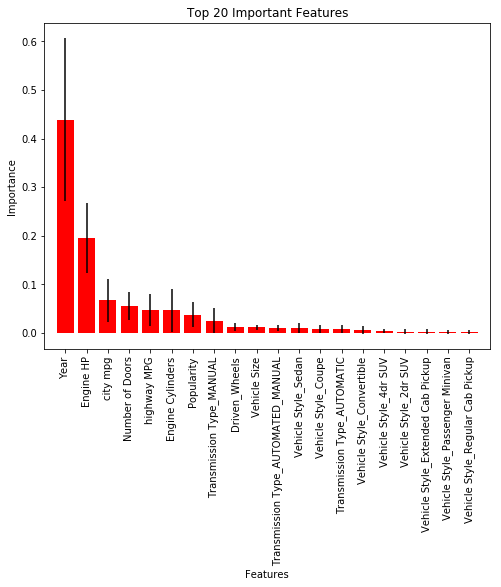

In [38]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Get the feature names
features = X_.columns.values

# Want the top 20 features, so limit the indices and labels
topLimit = 20  # limit to show up to, ex. top 10
indices = indices[0:topLimit]  # indices for features
topLabels = features[
    indices[0:topLimit]
]  # actual feature labels, we want to print these

# Plot the feature importances of the forest (top 20)
figsize = (8, 6)
plt.figure(figsize=figsize)
plt.title("Top 20 Important Features")
ax = plt.bar(
    range(topLimit), importances[indices], color="r", yerr=std[indices], align="center"
)
plt.xticks(rotation=90)
plt.xticks(range(topLimit), topLabels)
plt.xlim([-1, topLimit])
plt.xlabel("Features")
plt.ylabel("Importance")

## Training

In [39]:
X_ = pd.get_dummies(
    df.drop(["Make", "Model", "Engine Fuel Type", "Market Category", "MSRP"], axis=1)
)
y_ = df["MSRP"]

In [40]:
X_.shape

(10722, 34)

In [41]:
y_.shape

(10722,)

In [42]:
y_true = []
y_pred = []
X, y = np.array(X_), np.array(y_)

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
# x_scaler.fit(X)
# y_scaler.fit(y.reshape(-1, 1))

kf = KFold(n_splits=10, shuffle=True, random_state=2019)
for i, (train_idx, test_idx) in tqdm(enumerate(kf.split(X))):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    #     X_train = x_scaler.transform(X_train)
    #     y_train = y_scaler.transform(y_train.reshape(-1, 1)).reshape(-1)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    y_true.append(y_test)
    y_pred.append(model.predict(X_test))
    #     y_pred.append(y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test)).reshape(-1,1)))

    print("Train acc:", r2_score(y_train, model.predict(X_train)), end=" ")
    print("Test acc:", r2_score(y_test, model.predict(X_test)))
#     print('Test acc:', r2_score(y_test, y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test)).reshape(-1,1))))

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

print("\n", "OOB r2:", r2_score(y_true, y_pred))

1it [00:00,  2.78it/s]

Train acc: 0.990947545823 Test acc: 0.956913594055


2it [00:00,  2.82it/s]

Train acc: 0.989949742526 Test acc: 0.962979146158


3it [00:01,  2.84it/s]

Train acc: 0.988808075696 Test acc: 0.987849059391


4it [00:01,  2.85it/s]

Train acc: 0.993422275089 Test acc: 0.94166839009


5it [00:01,  2.86it/s]

Train acc: 0.991176010771 Test acc: 0.96334071097


6it [00:02,  2.86it/s]

Train acc: 0.995706999421 Test acc: 0.950227038018


7it [00:02,  2.86it/s]

Train acc: 0.989547461885 Test acc: 0.972394200862


8it [00:02,  2.87it/s]

Train acc: 0.985733747051 Test acc: 0.98134719338


9it [00:03,  2.87it/s]

Train acc: 0.991747764998 Test acc: 0.983213821224


10it [00:03,  2.87it/s]

Train acc: 0.990614416014 Test acc: 0.991336886202

 OOB r2: 0.968773863192


Text(0,0.5,'Importance')

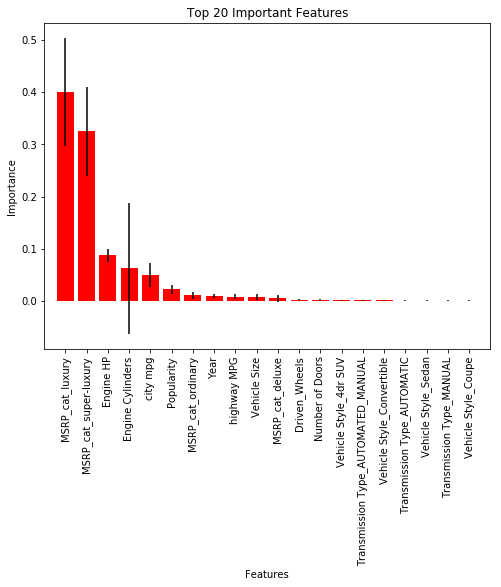

In [43]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Get the feature names
features = X_.columns.values

# Want the top 20 features, so limit the indices and labels
topLimit = 20  # limit to show up to, ex. top 10
indices = indices[0:topLimit]  # indices for features
topLabels = features[
    indices[0:topLimit]
]  # actual feature labels, we want to print these

# Plot the feature importances of the forest (top 20)
figsize = (8, 6)
plt.figure(figsize=figsize)
plt.title("Top 20 Important Features")
ax = plt.bar(
    range(topLimit), importances[indices], color="r", yerr=std[indices], align="center"
)
plt.xticks(rotation=90)
plt.xticks(range(topLimit), topLabels)
plt.xlim([-1, topLimit])
plt.xlabel("Features")
plt.ylabel("Importance")

+ Now we can **remove unimportant features** like Transmission Type, Vehicle Style, Driven Wheels, Number of Doors
+ Now it is evident from the above plot that **deducing MSRP categories first was critical for predicting exact MSRP values**.  

In [44]:
y_true[:10]

array([19100, 24599, 27880, 36850, 31180, 29470, 25045, 81013, 39280, 47095])

In [45]:
y_pred[:10]

array([ 19650.        ,  26606.73989899,  27748.25      ,  38772.        ,
        27411.35833333,  26644.825     ,  28209.10833333,  85841.4       ,
        34352.11287879,  39989.16666667])

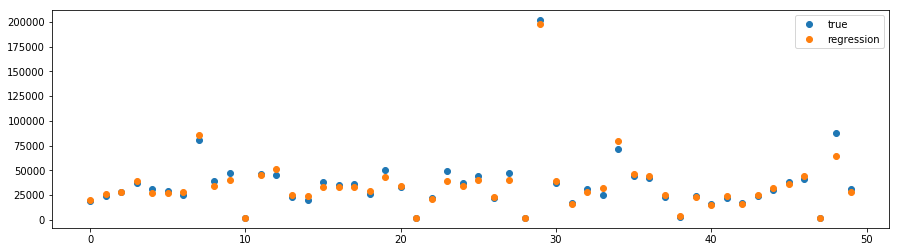

In [46]:
plt.figure(figsize=(15, 4))
plt.plot(y_true[:50], "o", label="true")
plt.plot(y_pred[:50], "o", label="regression")

plt.legend()

# Final Feature Selection and Model Training

+ Unimportant features will be removed and bigger models will be trained to obtain maximum performance.

## MSRP_cat training

Number of Driven Wheels and Vehicle Size are not categorical features
Altough I haven't plotted the graph between those and price, which might say against that. Will try that later.

In [47]:
X_ = pd.get_dummies(
    df.drop(
        ["Make", "Model", "Engine Fuel Type", "Market Category", "MSRP", "MSRP_cat"],
        axis=1,
    )
)
y_ = df["MSRP_cat"]

In [48]:
y_true = []
y_pred = []
X, y = np.array(X_), np.array(y_)

kf = KFold(n_splits=10, shuffle=True, random_state=2019)
for i, (train_idx, test_idx) in tqdm(enumerate(kf.split(X))):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    y_true.append(y_test)
    y_pred.append(clf.predict(X_test))

    print(
        "Train acc:",
        accuracy_score(y_train, clf.predict(X_train)),
        "F1:",
        f1_score(y_train, clf.predict(X_train), average="micro"),
        end=" ",
    )
    print(
        "Test acc:",
        accuracy_score(y_test, clf.predict(X_test)),
        "F1:",
        f1_score(y_test, clf.predict(X_test), average="micro"),
    )

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

print("\n", "OOB acc:", accuracy_score(y_true, y_pred))
print("OOB F1:", f1_score(y_true, y_pred, average="micro"))

2it [00:00,  7.11it/s]

Train acc: 0.998963623173 F1: 0.998963623173 Test acc: 0.994408201305 F1: 0.994408201305
Train acc: 0.999067260856 F1: 0.999067260856 Test acc: 0.994408201305 F1: 0.994408201305


4it [00:00,  7.33it/s]

Train acc: 0.99896373057 F1: 0.99896373057 Test acc: 0.992537313433 F1: 0.992537313433
Train acc: 0.998756476684 F1: 0.998756476684 Test acc: 0.995335820896 F1: 0.995335820896


6it [00:00,  7.34it/s]

Train acc: 0.998549222798 F1: 0.998549222798 Test acc: 0.993470149254 F1: 0.993470149254
Train acc: 0.998860103627 F1: 0.998860103627 Test acc: 0.992537313433 F1: 0.992537313433


8it [00:01,  7.38it/s]

Train acc: 0.99896373057 F1: 0.99896373057 Test acc: 0.993470149254 F1: 0.993470149254
Train acc: 0.999067357513 F1: 0.999067357513 Test acc: 0.988805970149 F1: 0.988805970149


10it [00:01,  7.42it/s]

Train acc: 0.998756476684 F1: 0.998756476684 Test acc: 0.995335820896 F1: 0.995335820896
Train acc: 0.998860103627 F1: 0.998860103627 Test acc: 0.994402985075 F1: 0.994402985075

 OOB acc: 0.993471367282
OOB F1: 0.993471367282


## Training

In [49]:
X_ = pd.get_dummies(
    df.drop(
        [
            "Make",
            "Model",
            "Engine Fuel Type",
            "Market Category",
            "Transmission Type",
            "Transmission Type",
            "Driven_Wheels",
            "Vehicle Style",
            "MSRP",
        ],
        axis=1,
    )
)
y_ = df["MSRP"]

In [50]:
y_true = []
y_pred = []
X, y = np.array(X_), np.array(y_)

kf = KFold(n_splits=10, shuffle=True, random_state=2019)
for i, (train_idx, test_idx) in tqdm(enumerate(kf.split(X))):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = RandomForestRegressor(n_estimators=50, max_features=6)
    model.fit(X_train, y_train)

    y_true.append(y_test)
    y_pred.append(model.predict(X_test))

    print("Train acc:", r2_score(y_train, model.predict(X_train)), end=" ")
    print("Test acc:", r2_score(y_test, model.predict(X_test)))

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

print("\n", "OOB r2:", r2_score(y_true, y_pred))

1it [00:00,  1.33it/s]

Train acc: 0.991396208597 Test acc: 0.970642747167


2it [00:01,  1.38it/s]

Train acc: 0.991244022577 Test acc: 0.971206194871


3it [00:02,  1.38it/s]

Train acc: 0.989823553108 Test acc: 0.986251016968


4it [00:02,  1.39it/s]

Train acc: 0.993191226895 Test acc: 0.957448803314


5it [00:03,  1.39it/s]

Train acc: 0.990877791868 Test acc: 0.968551008058


6it [00:04,  1.38it/s]

Train acc: 0.994052160286 Test acc: 0.936948329456


7it [00:05,  1.38it/s]

Train acc: 0.989706594561 Test acc: 0.986295515136


8it [00:05,  1.38it/s]

Train acc: 0.990503570166 Test acc: 0.988657054439


9it [00:06,  1.38it/s]

Train acc: 0.991153688946 Test acc: 0.981890308648


10it [00:07,  1.38it/s]

Train acc: 0.989950754841 Test acc: 0.98952001157

 OOB r2: 0.971590735221


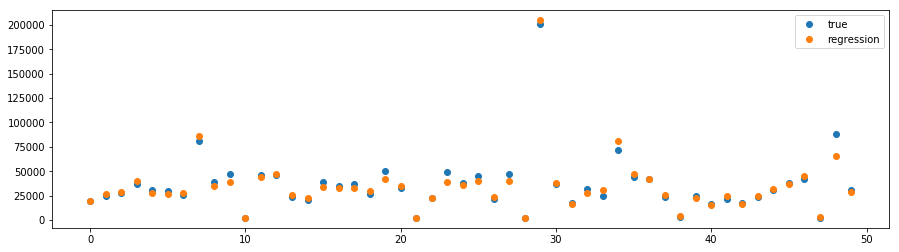

In [51]:
plt.figure(figsize=(15, 4))
plt.plot(y_true[:50], "o", label="true")
plt.plot(y_pred[:50], "o", label="regression")

plt.legend()

## Submission

In [52]:
dft_orig = pd.read_csv("test_data.csv")
dft = dft_orig.copy()
dft.loc[:, "Driven_Wheels"] = dft["Driven_Wheels"].apply(lambda x: driven_wheels_map[x])
dft.loc[:, "Vehicle Size"] = dft["Vehicle Size"].apply(lambda x: vehicle_size_map[x])

dft.loc[dft["Number of Doors"].isnull(), "Number of Doors"] = 4
dft.loc[dft["Engine HP"].isnull(), "Engine HP"] = ENGINE_HP_MEAN
dft.loc[dft["Engine Cylinders"].isnull(), "Engine Cylinders"] = 0

print(dft.isnull().sum())

X_ = pd.get_dummies(
    dft.drop(["Make", "Model", "Engine Fuel Type", "Market Category", "MSRP"], axis=1)
)
dft.loc[:, "MSRP_cat"] = clf.predict(np.array(X_))

X_ = pd.get_dummies(
    dft.drop(
        [
            "Make",
            "Model",
            "Engine Fuel Type",
            "Market Category",
            "Transmission Type",
            "Transmission Type",
            "Driven_Wheels",
            "Vehicle Style",
            "MSRP",
        ],
        axis=1,
    )
)
X_.loc[:, "MSRP_cat_super-luxury"] = 0

dft_orig["MSRP"] = model.predict(X_).astype("int").reshape(-1)

Make                    0
Model                   0
Year                    0
Engine Fuel Type        0
Engine HP               0
Engine Cylinders        0
Transmission Type       0
Driven_Wheels           0
Number of Doors         0
Market Category       366
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                 1192
dtype: int64


In [53]:
dft_orig.to_csv("submission.csv", index=False, float_format="%d")